In [1]:
import pandas as pd
import os.path as op
import nibabel as nb
import numpy as np
import json
import trimesh
import open3d as o3d
from tools import smooth_csd
import matplotlib.pylab as plt
from matplotlib import cm, colors
from utilities import files
import tqdm.auto as tqdm
from copy import copy
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, minmax_scale
from sklearn.manifold import MDS
from scipy.spatial.distance import euclidean

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [112]:
def data_to_rgb(data, n_bins, cmap, vmin, vmax, vcenter=0, ret_map=False, norm="TS"):
    if norm == "TS":
        divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    elif norm == "N":
        divnorm = colors.Normalize(vmin=vmin, vmax=vmax)
    elif norm == "LOG":
        divnorm = colors.LogNorm(vmin=vmin, vmax=vmax, clip=True)
    c = cm.ScalarMappable(divnorm, cmap=cmap)
    bins = np.histogram_bin_edges(data, bins=n_bins)
    bin_ranges = list(zip(bins[:-1], bins[1:]))
    colour_mapped = np.zeros((data.shape[0], 4))
    for br_ix, br in enumerate(bin_ranges):
        map_c = (data >= br[0]) & (data <= br[1])
        colour_mapped[map_c,:] = c.to_rgba(bins[1:][br_ix])
    
    if not ret_map:
        return colour_mapped
    elif ret_map:
        return colour_mapped, c


def plot_csd(smooth_csd, list_ROI_vertices, bb_path, times, ax, cb=True, cmap="RdBu_r", vmin_vmax=None):
    layer_labels = ["I", "II", "III", "IV", "V", "VI"]
    with open(bb_path, "r") as fp:
        bb = json.load(fp)
    bb = [np.array(bb[i])[list_ROI_vertices] for i in bb.keys()]
    bb_mean = [np.mean(i) for i in bb]
    bb_std = [np.std(i) for i in bb]
    max_smooth = np.max(np.abs(smooth_csd))
    if vmin_vmax == None:
        divnorm = colors.TwoSlopeNorm(vmin=-max_smooth, vcenter=0, vmax=max_smooth)
    else:
        divnorm = colors.TwoSlopeNorm(vmin=vmin_vmax[0], vcenter=0, vmax=vmin_vmax[1])
    extent = [times[0], times[-1], 1, 0]
    csd_imshow = ax.imshow(
        smooth_csd, norm=divnorm, origin="lower",
        aspect="auto", extent=extent,
        cmap=cmap
    )
    ax.set_ylim(1,0)
    for l_ix, th in enumerate(np.cumsum(bb_mean)):
            ax.axhline(th, linestyle=(0, (5,5)), c="black", lw=0.5)
            ax.axhspan(th-bb_std[l_ix], th+bb_std[l_ix], alpha=0.05, color="black", lw=0)
            ax.annotate(layer_labels[l_ix],[times[0]+0.01, th-0.01],size=15)
    if cb:
        plt.colorbar(csd_imshow, ax=ax)
    plt.tight_layout()


In [3]:
info_path = "/home/common/bonaiuto/multiburst/derivatives/processed/sub-001/multilayer_11/info.json"
with open(info_path, "r") as fp:
    info = json.load(fp)

In [4]:
atlas = pd.read_csv(info["atlas"])
atlas_labels = np.load(info["atlas_colors_path"])

csd_files = files.get_files(
    op.join(info["subject_path"], "inverted"),
    "time_CSD", "npy"
)[2]

In [5]:
times = {
    "visual": np.linspace(-0.2, 0.8, num=601),
    "motor": np.linspace(-0.5, 0.5, num=601)
}

In [6]:
ROI_labels = ["L_V1_ROI", "R_V1_ROI"]
total_ix = np.arange(atlas_labels.shape[0])
ROI_vertices = {i: total_ix[[i == al.decode("utf=8") for al in atlas_labels]] for i in ROI_labels}
cds = np.load(csd_files[1])

In [7]:
true_CSD = {}
for l in ROI_labels:
    true_CSD[l] = []
    for rv in ROI_vertices[l]:
        true_CSD[l].append(cds[rv, :, :])

In [9]:
erp_ixs = np.where((times["visual"] >= 0) & (times["visual"] <= 0.2))[0]

In [10]:
csds = np.array([i[:,erp_ixs].flatten() for i in true_CSD["L_V1_ROI"]])
csds.shape

(725, 1331)

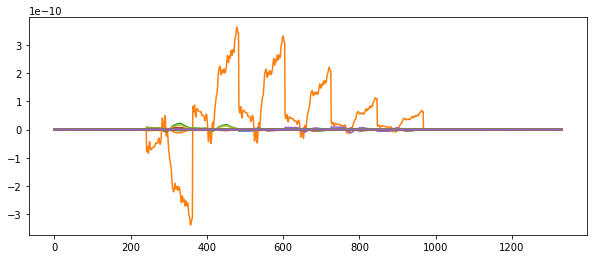

In [11]:
f, ax = plt.subplots(1, figsize=(10, 4))
ax.plot(csds.T);

In [89]:
mean_cds = csds.std(axis=1)
nan_map = np.isnan(mean_cds)
prc_minmax = np.percentile(mean_cds[~nan_map], 0.1), np.percentile(mean_cds[~nan_map], 99.9)
outlier_map = (mean_cds < prc_minmax[0]) | (mean_cds > prc_minmax[1])
unwanted_map = nan_map | outlier_map

2

In [92]:
SMOOTH_CSD = {}
for l in ROI_labels:
    SMOOTH_CSD[l] = []
    for rv in ROI_vertices[l]:
        SMOOTH_CSD[l].append(smooth_csd(cds[rv, :, :], info["n_surf"]))

smooth_csds = np.array(SMOOTH_CSD["L_V1_ROI"])
smooth_csds = smooth_csds[~unwanted_map]

In [14]:
csds.shape

(725, 1331)

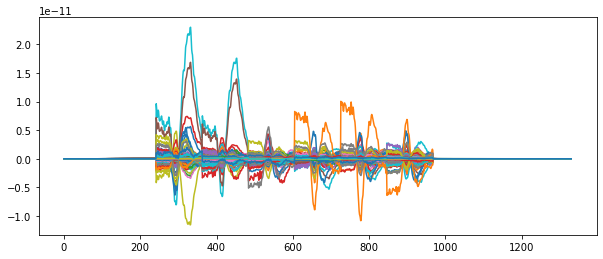

In [93]:
f, ax = plt.subplots(1, figsize=(10, 4))
ax.plot(csds[~unwanted_map].T);

In [94]:
scaler = RobustScaler()
ds = scaler.fit_transform(csds[~unwanted_map])
pca = PCA(n_components=30)
ds_pca = pca.fit_transform(ds)

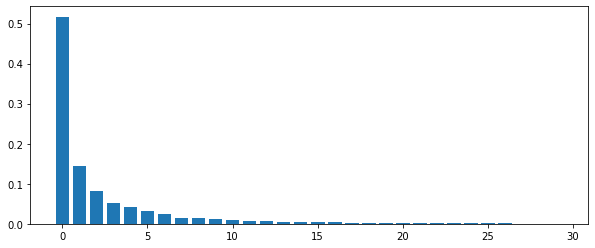

In [95]:
f, ax = plt.subplots(1, figsize=(10, 4), facecolor="white")
ax.bar(np.arange(pca.explained_variance_ratio_.shape[0]), pca.explained_variance_ratio_);
plt.savefig("/home/mszul/git/DANC_multilayer_laminar/output/pca_var_exp_ratio.png", dpi=300)

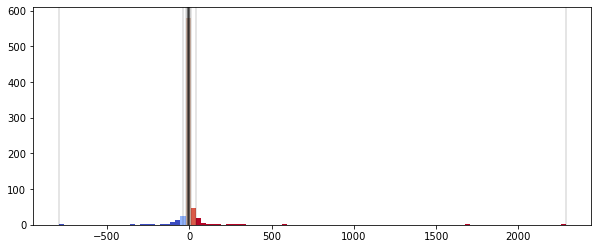

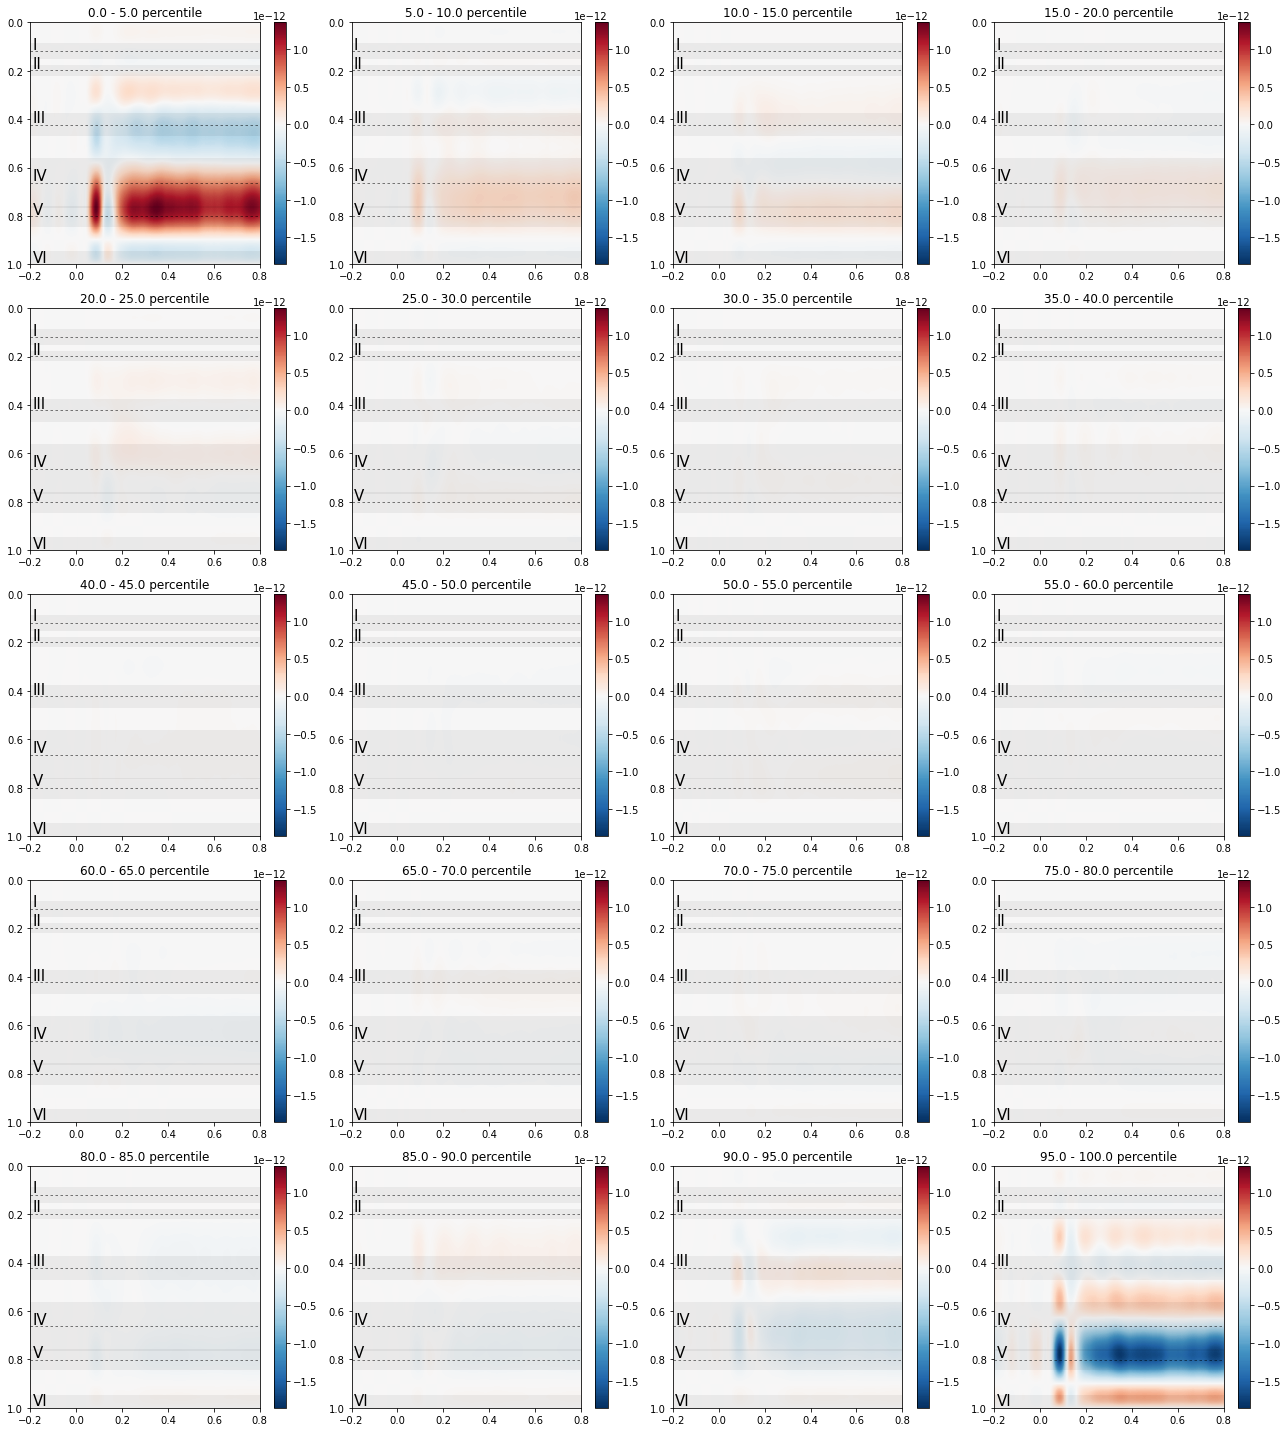

In [96]:
pc_component = 0

data_pc = ds_pca[:,pc_component]
prct = np.linspace(0,100, num=21)
prc_bounds = list(zip(prct[:-1], prct[1:]))

colormap_dist, mappable = data_to_rgb(np.array(data_pc), 100, "coolwarm", -50, 50, ret_map=True)

f, ax = plt.subplots(1, figsize=(10, 4), facecolor="white")
hist, bins, barlist = ax.hist(data_pc, bins=100);
for cc in prct:
    ax.axvline(np.percentile(data_pc, cc), lw=0.2, c="black")
for ix, xx in enumerate(barlist):
    plt.setp(xx, "facecolor", mappable.to_rgba(bins[ix+1]))
plt.savefig("/home/mszul/git/DANC_multilayer_laminar/output/PC_{}_colormap_prcr.png".format(str(pc_component).zfill(2)), dpi=300)


csd_bounds = []
for ix, pb in enumerate(prc_bounds):
    bounds = [np.percentile(data_pc, i) for i in pb]
    pr_mask = np.where((data_pc >= bounds[0]) & (data_pc < bounds[1]))[0]
    mean_smooth_csd = np.mean(smooth_csds[pr_mask], axis=0)
    baseline = np.mean(mean_smooth_csd[:, np.where(times["visual"] < -0.01)], axis=2)
    csd_bounds.append(mean_smooth_csd - baseline)
csd_bounds = np.array(csd_bounds)

v_mm = [csd_bounds.min(), csd_bounds.max()]

f, ax = plt.subplots(5,4, figsize=(18, 20), facecolor="white")
ax = ax.flatten()
for ix, pb in enumerate(prc_bounds):
    ax[ix].set_title("{} - {} percentile".format(*pb))
    bounds = [np.percentile(data_pc, i) for i in pb]
    pr_mask = np.where((data_pc >= bounds[0]) & (data_pc < bounds[1]))[0]
    mean_smooth_csd = np.mean(smooth_csds[pr_mask], axis=0)
    baseline = np.mean(mean_smooth_csd[:, np.where(times["visual"] < -0.01)], axis=2)
    plot_csd(
        mean_smooth_csd - baseline, ROI_vertices["L_V1_ROI"],
        info["big_brain_layers_path"], times["visual"], ax[ix],
        vmin_vmax=v_mm
    )

plt.tight_layout()
plt.savefig("/home/mszul/git/DANC_multilayer_laminar/output/PC_{}_CSD_mean_baseline.png".format(str(pc_component).zfill(2)), dpi=300)

In [31]:
# PC SCORE

pc_component = 0
data_pc = ds_pca[:,pc_component]
colormap_dist, mappable = data_to_rgb(np.array(data_pc), 100, "coolwarm", -50, 50, ret_map=True)

data_colour_map = np.repeat(np.array([[0, 1, 0.224]]), ROI_vertices["L_V1_ROI"].shape[0], axis=0)
data_colour_map[~unwanted_map] = colormap_dist[:,:3]
gray = np.array([0.5, 0.5, 0.5])
brain = nb.load(info["pial_ds_nodeep_inflated"])
vertices, faces = brain.agg_data()
colours = np.repeat(gray.reshape(1,-1), vertices.shape[0], axis=0)
for ix, v in enumerate(ROI_vertices["L_V1_ROI"]):
    colours[v] = data_colour_map[ix][:3]

mesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=False, validate=False)
mesh = mesh.as_open3d
mesh.compute_vertex_normals(normalized=True)
mesh.vertex_colors = o3d.utility.Vector3dVector(colours)
vxmask = np.array([i.decode("utf=8")[0] == "R" for i in atlas_labels]) | np.array([i.decode("utf=8")[0] == "?" for i in atlas_labels])
mesh.remove_vertices_by_mask(vxmask)
o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

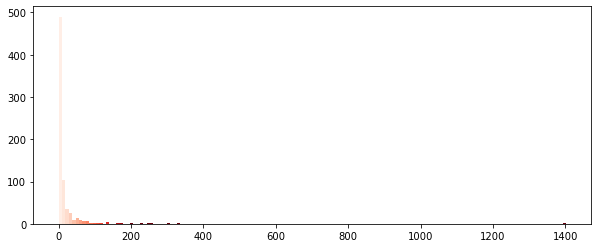

In [144]:
# ABS PC SCORE

pc_component = 1
data_pc = ds_pca[:,pc_component]
colormap_dist, mappable = data_to_rgb(np.abs(data_pc), 150, "Reds", 0, 200, ret_map=True, norm="N")

f, ax = plt.subplots(1, figsize=(10, 4), facecolor="white")
hist, bins, barlist = ax.hist(np.abs(data_pc), bins=150);
for ix, xx in enumerate(barlist):
    plt.setp(xx, "facecolor", mappable.to_rgba(bins[ix+1]))
plt.savefig("/home/mszul/git/DANC_multilayer_laminar/output/PC_{}_colormap_ABS_PC_SCORE.png".format(str(pc_component).zfill(2)), dpi=300)

data_colour_map = np.repeat(np.array([[0, 1, 0.224]]), ROI_vertices["L_V1_ROI"].shape[0], axis=0)
data_colour_map[~unwanted_map] = colormap_dist[:,:3]

gray = np.array([0.5, 0.5, 0.5])
brain = nb.load(info["pial_ds_nodeep_inflated"])
vertices, faces = brain.agg_data()
colours = np.repeat(gray.reshape(1,-1), vertices.shape[0], axis=0)
for ix, v in enumerate(ROI_vertices["L_V1_ROI"]):
    colours[v] = data_colour_map[ix][:3]

mesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=False, validate=False)
mesh = mesh.as_open3d
mesh.compute_vertex_normals(normalized=True)
mesh.vertex_colors = o3d.utility.Vector3dVector(colours)
vxmask = np.array([i.decode("utf=8")[0] == "R" for i in atlas_labels]) | np.array([i.decode("utf=8")[0] == "?" for i in atlas_labels])
mesh.remove_vertices_by_mask(vxmask)
o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

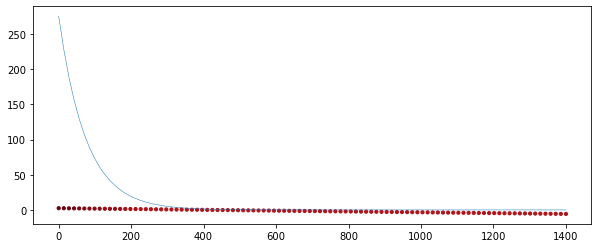

In [141]:

f, ax = plt.subplots(1, 1, figsize=(10, 4), facecolor="white")


p = np.polyfit(bins[1:][~np.isinf(np.log(hist))], np.log(hist)[~np.isinf(np.log(hist))], 1, w=np.sqrt(hist[~np.isinf(np.log(hist))]))
a = np.exp(p[1])
b = p[0]
x = np.linspace(0, 1400, num=100)
y = a * np.exp(b * x)

ax.plot(x, y, lw=0.5);

cols = data_to_rgb(y, 20, "Reds", y.min(), y.max(), norm="LOG")

ax.scatter(x, np.log10(y), s=10, c=cols)

In [ ]:
f, ax = plt.subplots(2, 2, figsize=(10, 8), facecolor="white")
ax = ax.flatten()
for pcomp in range(4):
    eigenvector_csd = smooth_csd(np.array(np.split(pca.components_[pcomp], 11)), info["n_surf"])
    plot_csd(
            eigenvector_csd, ROI_vertices["L_V1_ROI"],
            info["big_brain_layers_path"], times["visual"][erp_ixs], ax[pcomp], cmap="viridis"
        )
    ax[pcomp].set_title("PC {} eigenvector".format(str(pc_component).zfill(2)))
plt.savefig("/home/mszul/git/DANC_multilayer_laminar/output/eigenvectors_CSD.png", dpi=300)